In [27]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

In [30]:
!ls /content

celeba.zip		   img_align_celeba	 subset_df.csv
conditional_generator.pth  list_attr_celeba.txt
drive			   sample_data


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Reloading Generator

In [29]:
LATENT_DIM = 100
ATTR_DIM = 3
FEATURE_G = 64

class ConditionalGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.attr_fc = nn.Linear(ATTR_DIM, LATENT_DIM)

        self.net = nn.Sequential(
            nn.ConvTranspose2d(LATENT_DIM*2, FEATURE_G*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(FEATURE_G*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(FEATURE_G*8, FEATURE_G*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURE_G*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(FEATURE_G*4, FEATURE_G*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURE_G*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(FEATURE_G*2, FEATURE_G, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURE_G),
            nn.ReLU(True),

            nn.ConvTranspose2d(FEATURE_G, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, attrs):
        attr_embed = self.attr_fc(attrs)
        attr_embed = attr_embed.unsqueeze(2).unsqueeze(3)

        x = torch.cat([noise, attr_embed], dim=1)
        return self.net(x)

## Load Trained Model

In [31]:
G = ConditionalGenerator().to(device)
G.load_state_dict(torch.load("/content/conditional_generator.pth", map_location=device))
G.eval()

ConditionalGenerator(
  (attr_fc): Linear(in_features=3, out_features=100, bias=True)
  (net): Sequential(
    (0): ConvTranspose2d(200, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=

In [32]:
# Attribute Mapping Helper
ATTRIBUTES = [
    "Smiling",
    "Eyeglasses",
    "Male"
]

#### Text -> Attribute Vector

In [33]:
def build_attr(smiling=0, glasses=0, male=0):
    return torch.tensor([[smiling, glasses, male]], dtype=torch.float32).to(device)

#### Generate Single Face

In [34]:
def generate_face(attr_tensor):
    noise = torch.randn(1, LATENT_DIM, 1, 1, device=device)

    with torch.no_grad():
        fake = G(noise, attr_tensor).cpu()

    fake = fake * 0.5 + 0.5
    img = fake[0].permute(1,2,0)

    plt.imshow(img)
    plt.axis("off")

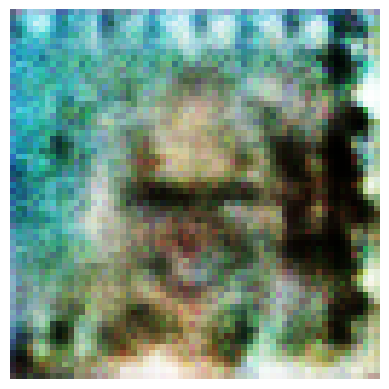

In [35]:
attr = build_attr(
    smiling=1,
    glasses=1,
    male=1
)

generate_face(attr)

In [36]:
def generate_grid(attr_tensor, n=16):
    noise = torch.randn(n, LATENT_DIM, 1, 1, device=device)
    attrs = attr_tensor.repeat(n,1)

    with torch.no_grad():
        fake = G(noise, attrs).cpu()

    fake = fake * 0.5 + 0.5
    grid = torchvision.utils.make_grid(fake, nrow=4)

    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")

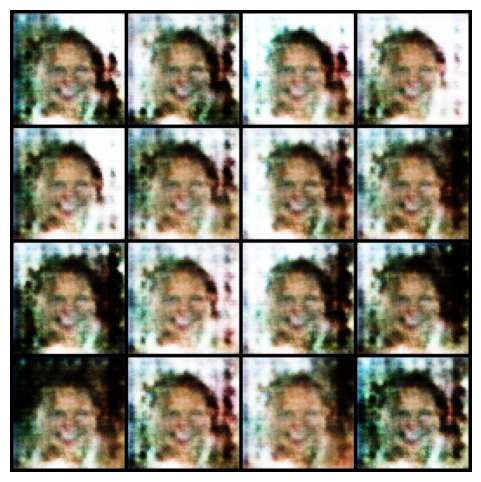

In [37]:
attr = build_attr(1,0,1)   # smiling male, no glasses
generate_grid(attr, 16)